# Emails dataset
https://snap.stanford.edu/data/email-Eu-core.html


## 1. Load of data

In [3]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import pandas as pd 
import os
import sys
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import gensim
import math

In [4]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import nltk
import pprint

from sklearn import cluster
from sklearn import metrics
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF

from nltk.cluster import KMeansClusterer
import nltk
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import f1_score

from mpl_toolkits.mplot3d import Axes3D


In [6]:
edges = pd.read_csv('../data/email-Eu-core.txt', sep=' ')
edges.columns=['from', 'to']
edges.head()


from  to
0     2   3
1     2   4
2     5   6
3     5   7
4     8   9

In [7]:
departments = pd.read_csv('../data/email-Eu-core-department-labels.txt', sep=' ', header=None)
departments.columns=['node', 'department']
departments = departments.sort_index()


departments.head()


node  department
0     0           1
1     1           1
2     2          21
3     3          21
4     4          21

In [8]:
len(pd.unique(pd.concat([edges['from'], edges['to']], sort=False)))

1005

In [9]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 2 columns):
node          1005 non-null int64
department    1005 non-null int64
dtypes: int64(2)
memory usage: 15.8 KB


In [10]:
departments_array = []
for x, row in departments.iterrows(): 
    departments_array.append(row['department'])
    
departments_array.sort()
len(departments_array)

1005

In [13]:
#departments dictionary: node_number -> department number
departm_dic = {}
for x, row in departments.iterrows():
    departm_dic[row[0]] = row[1]
# print(departm_dic)

In [14]:
len(departm_dic)

1005

In [15]:
dep_nunique = departments.groupby('department')['node'].nunique().sort_values(ascending=False)
ten_deps = dep_nunique.head(10)

print (ten_deps)

department
4     109
14     92
1      65
21     61
15     55
7      51
0      49
10     39
17     35
9      32
Name: node, dtype: int64


In [16]:
nodes = []
deps = []
nodes_dict = {}

for index, row in departments.iterrows():
    if (row['department'] in ten_deps):
        nodes.append(row['node'])
        deps.append(row['department'])
        nodes_dict[row['node']] = row['department']

ten_departments = pd.DataFrame(list(zip(nodes, deps)), 
               columns =['node', 'department']) 

# ten_departments.groupby('department')['node'].nunique().sort_values(ascending=False)
ten_departments.head(6)

node  department
0     0           1
1     1           1
2     2          21
3     3          21
4     4          21
5     7          14

In [17]:
len(ten_departments) #memebres of the 10 diggest depratment 

588

In [18]:
print(nodes_dict.get(2))
print(2 in nodes_dict)
print(6 in nodes_dict)

21
True
False


In [19]:
toes = []
froms = []

for index, row in edges.iterrows():
    if (row['from'] in nodes_dict and row['to'] in nodes_dict):
        toes.append(row['to'])
        froms.append(row['from'])
 
ten_edges = pd.DataFrame(list(zip(froms, toes)), 
               columns =['from', 'to']) 

In [20]:
unique_edges = pd.unique(pd.concat([ten_edges['from'], ten_edges['to']], sort=False))
unique_edges.sort()
len(unique_edges)

568

In [21]:
#deletion nodes that w/o edges from nodes_dict and ten_departments
ten_departments2 = ten_departments.set_index("node", drop = False)

for index, row in ten_departments2.iterrows():
    if (row['node'] not in unique_edges):
        ten_departments2 = ten_departments2.drop(row['node'])

len(ten_departments2)

568

In [22]:
len(ten_departments2) == len(pd.unique(pd.concat([ten_edges['from'], ten_edges['to']], sort=False)))

True

In [23]:
G = nx.Graph()
G.add_nodes_from(ten_edges['from'])
G.add_nodes_from(ten_edges['to'])

for index, row in ten_edges.iterrows():
    G.add_edge(row["from"], row["to"], weight = 1)

In [24]:
G_full = nx.Graph()
G_full.add_nodes_from(edges['from'])
G_full.add_nodes_from(edges['to'])

for index, row in edges.iterrows():
    G_full.add_edge(row["from"], row["to"], weight = 1)

In [25]:
print(len(G), len(G_full))

568 1005


In [26]:
dep_freq = departments['department'].value_counts()
ten_dep_freq = ten_departments['department'].value_counts()


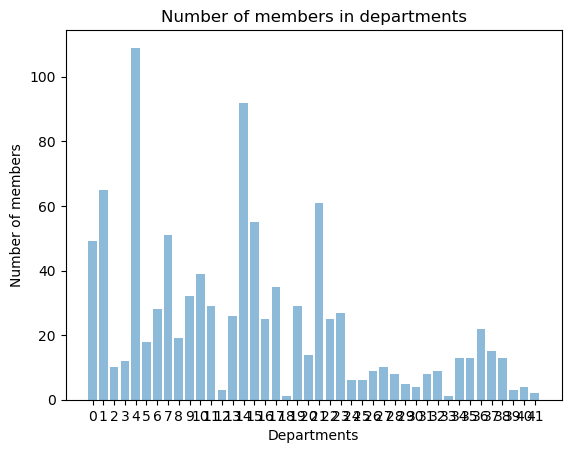

In [27]:
performance = []
objects = range(42)
for i in objects:
    performance.append(dep_freq[i])
y_pos = np.arange(len(objects))

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of members')
plt.xlabel('Departments')
plt.title('Number of members in departments')

plt.show()

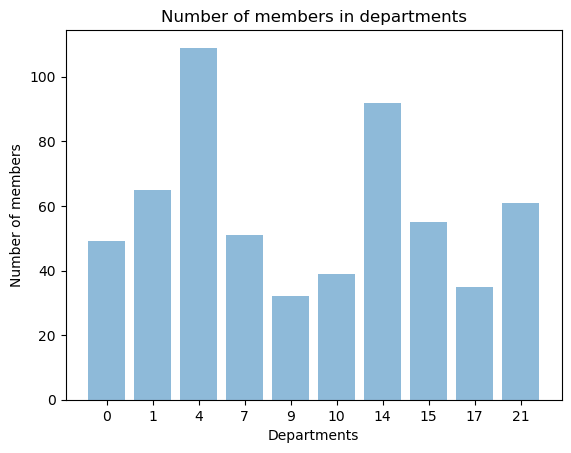

In [28]:
ten_performance = []
ten_objects = ten_dep_freq.index
ten_objects = ten_objects.sort_values()
ten_objects.sort

for i in ten_objects:
    ten_performance.append(ten_dep_freq[i])

ten_y_pos = np.arange(len(ten_objects))

plt.bar(ten_y_pos, ten_performance, align='center', alpha=0.5)
plt.xticks(ten_y_pos, ten_objects)
plt.ylabel('Number of members')
plt.xlabel('Departments')
plt.title('Number of members in departments')

plt.show()

In [29]:
#input for Gephi
with open('data.gdf', 'w') as f:
    f.write('nodedef>name VARCHAR,department VARCHAR,label VARCHAR\n')
    for index, row in departments.iterrows():
        f.write('{},{}\n'.format(row['node'], row['department']))
    f.write('edgedef>source VARCHAR,target VARCHAR, weight DOUBLE\n')
    for index, row in edges.iterrows(): 
        f.write('{},{}\n'.format(row['from'], row['to'], 1))

### Node2Vec

# 3. seeded node2vec usage

In [30]:
len(G_full) #all departments graph 

1005

In [31]:
# #add weightes to the edges
# for edge in G_full.edges():
#             G_full[edge[0]][edge[1]]['weight'] = 1

# nx_G = G_full.to_undirected() #read_graph() - returns: deepcopy  
# g = Graph(nx_G, 'false', 1, 1) #__init__(self, nx_G, is_directed, p, q)
# g.preprocess_transition_probs() 
# walks = g.simulate_walks(2, 2) #G.simulate_walks(args.num_walks, args.walk_length) - works for walk_length max 2

# learn_embeddings(walks)

## 4. Table: properties vs. adjusted_rand_score

In [32]:
# departm_dic = []

def calc_scores (G, lables_dic, num_clusters, walk_length=80, num_walks=10, p=1, q=1):
    print ('walk_length:', walk_length, ', num_walks:', num_walks, ', p:', p, ', q:', q)
    
    #node2vec
    node2vec = Node2Vec(G, dimensions=10, walk_length = walk_length, num_walks=num_walks, p=p, q=q)
    model = node2vec.fit(window=10, min_count=1)
    
    #clustering
    print('clustering started')
    X = model[model.wv.vocab]    
    kmeans = cluster.KMeans(n_clusters=num_clusters, random_state=25)
    kmeans.fit(X)
    assigned_clusters = kmeans.labels_
    
    #labels sorting: so assigned_clusters and sorted_lables are in the same order of nodes 
    sorted_lables = []
    nodes_order = []
    nodes = list(model.wv.vocab)
    for i, node in enumerate(nodes):
        nodes_order.append(int(node))
        sorted_lables.append(lables_dic[int(node)])

    #scores
    adj_rand_score = adjusted_rand_score(assigned_clusters, sorted_lables)
    f1_macro = f1_score(sorted_lables, assigned_clusters, average='macro')  
    
    return adj_rand_score, f1_macro

In [33]:
# (departm_dic)

## 5. Prepare input for Gephi:
We'll output our data into a format recognizable by Gephi.

In [39]:
clusters_df = pd.DataFrame(columns=['node', 'cluster', 'department'])

clusters_df['cluster'] = assigned_clusters
clusters_df['node'] = nodes_order
clusters_df['department'] = sorted_departaments

clusters_df.head()

# print(clusters_df)

NameError: name 'assigned_clusters' is not defined

In [40]:
len(clusters_df)

0

In [41]:
clusters_df.values

array([], shape=(0, 3), dtype=object)

In [42]:
with open('clusters.gdf', 'w') as f:
    f.write('nodedef>name VARCHAR,cluster_id VARCHAR,label VARCHAR, dep_name INT\n')
    for index, row in clusters_df.iterrows():
        f.write('{},{},{}\n'.format(row['node'], row['cluster'], row['department']))
    f.write('edgedef>source VARCHAR,target VARCHAR\n')
    for index, row in edges.iterrows(): 
        f.write('{},{}\n'.format(row['from'], row['to']))

## 6. Tables: parametres sensitivity

### 6.1 num_walks testing

In [43]:
walk_lengths_arr = []
num_walks_arr = []
adj_scores = []
f1_scores = []
clusters_10 = 10

for i in range(80, 90, 10): #walk_length = 80
    for j in range(10, 15, 1): # num_walks = 10
        adj_score, f1_macro = calc_scores(G, departm_dic, clusters_10, i, j)
        adj_scores.append(adj_score)
        f1_scores.append(f1_macro)
        walk_lengths_arr.append(i)
        num_walks_arr.append(j)

walks_test = pd.DataFrame(list(zip(walk_lengths_arr, num_walks_arr, adj_scores, f1_scores)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

walk_length: 80 , num_walks: 10 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 11 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 11/11 [00:22<00:00,  2.07s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 12 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 12/12 [00:25<00:00,  2.09s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 13 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 14 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 14/14 [00:28<00:00,  2.05s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 6.2 walk_length testing

In [44]:
walk_lengths_arr2 = []
num_walks_arr2 = []
adj_scores2 = []
f1_scores2 = []

for i in range(60, 100, 10): #walk_length = 80
    for j in range(10, 11, 1): # num_walks = 10
        adj_score2, f1_macro2 = calc_scores(G, departm_dic, clusters_10, i, j)
        adj_scores2.append(adj_score2)
        f1_scores2.append(f1_macro2)
        walk_lengths_arr2.append(i)
        num_walks_arr2.append(j)

length_test = pd.DataFrame(list(zip(walk_lengths_arr2, num_walks_arr2, adj_scores2, f1_scores2)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

walk_length: 60 , num_walks: 10 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 70 , num_walks: 10 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 90 , num_walks: 10 , p: 1 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 6.3 p's testing

In [45]:
Ps = []
adj_scores3 = []
f1_scores3 = []

for i in np.arange(0.2, 2, 0.2): #p
    adj_score3, f1_macro3 = calc_scores(G, departm_dic,clusters_10, 80, 10, i)
    adj_scores3.append(adj_score3)
    f1_scores3.append(f1_macro3)
    Ps.append(i)

p_test = pd.DataFrame(list(zip(Ps, adj_scores3, f1_scores3)), 
               columns =['p','adj_score', 'f1_score']) 

walk_length: 80 , num_walks: 10 , p: 0.2 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 0.4 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 0.6000000000000001 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:23<00:00,  2.30s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 0.8 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.0 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:22<00:00,  2.26s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.2 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:26<00:00,  2.64s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.4000000000000001 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.6 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:24<00:00,  2.40s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.8 , q: 1


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 6.4 q's testing

In [46]:
Qs = []
adj_scores4 = []
f1_scores4 = []

for i in np.arange(0.2, 2, 0.2): #p
    adj_score4, f1_macro4 = calc_scores(G, departm_dic, clusters_10, 80, 10, 1, i)
    adj_scores4.append(adj_score4)
    f1_scores4.append(f1_macro4)
    Qs.append(i)

q_test = pd.DataFrame(list(zip(Qs, adj_scores4, f1_scores4)), 
               columns =['q','adj_score', 'f1_score']) 

walk_length: 80 , num_walks: 10 , p: 1 , q: 0.2


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:21<00:00,  2.15s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 0.4


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 0.6000000000000001


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 0.8


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:25<00:00,  2.52s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1.0


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:24<00:00,  2.50s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1.2


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:25<00:00,  2.55s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1.4000000000000001


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1.6


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:34<00:00,  3.47s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1.8


Generating walks (CPU: 1): 100%|██████████| 10/10 [00:23<00:00,  2.39s/it]


clustering started


C:\Users\Adeliia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Adeliia\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [47]:
walks_test

walk_length  num_walks  adj_score  f1_score
0           80         10   0.505484  0.000000
1           80         11   0.603412  0.000000
2           80         12   0.603856  0.000000
3           80         13   0.603330  0.055517
4           80         14   0.634330  0.011905

In [48]:
length_test

walk_length  num_walks  adj_score  f1_score
0           60         10   0.612211  0.010811
1           70         10   0.567745  0.044033
2           80         10   0.589852  0.013413
3           90         10   0.599572  0.053909

In [49]:
p_test

p  adj_score  f1_score
0  0.2   0.586950  0.001235
1  0.4   0.609573  0.001235
2  0.6   0.605875  0.061536
3  0.8   0.602747  0.008000
4  1.0   0.596758  0.004633
5  1.2   0.564576  0.044715
6  1.4   0.609358  0.014321
7  1.6   0.564748  0.009249
8  1.8   0.556443  0.000000

In [50]:
q_test

q  adj_score  f1_score
0  0.2   0.645180  0.012815
1  0.4   0.610921  0.000000
2  0.6   0.599210  0.033513
3  0.8   0.575781  0.006965
4  1.0   0.558572  0.012619
5  1.2   0.577459  0.068815
6  1.4   0.543996  0.020322
7  1.6   0.547116  0.014259
8  1.8   0.554685  0.046259

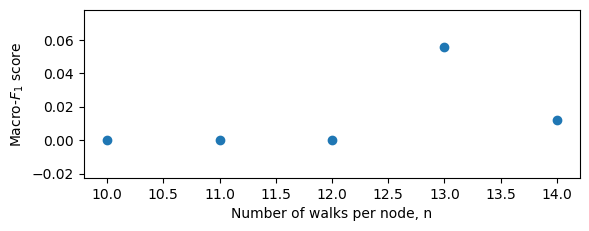

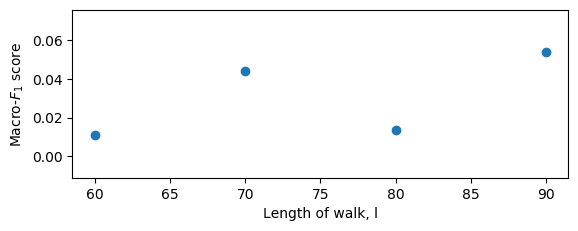

In [52]:
fig = plt.figure()
fig.add_subplot(211)
plt.scatter(walks_test['num_walks'], walks_test['f1_score'])
plt.xlabel('Number of walks per node, n')
plt.ylabel('Macro-$F_1$ score')
plt.show()

fig = plt.figure()
fig.add_subplot(212)
plt.scatter(length_test['walk_length'], length_test['f1_score'])
plt.xlabel('Length of walk, l')
plt.ylabel('Macro-$F_1$ score')
plt.show()


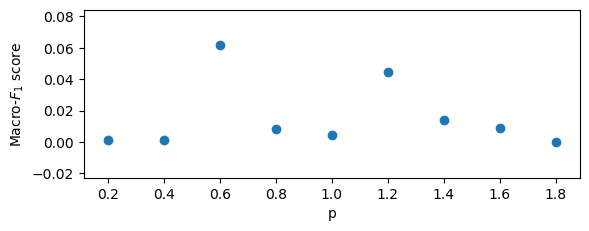

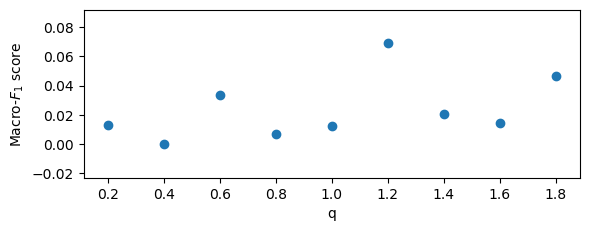

In [53]:
fig = plt.figure()
fig.add_subplot(211)
plt.scatter(p_test['p'], p_test['f1_score'])
plt.xlabel('p')
plt.ylabel('Macro-$F_1$ score')
plt.show()

fig = plt.figure()
fig.add_subplot(212)
plt.scatter(q_test['q'], q_test['f1_score'])
plt.xlabel('q')
plt.ylabel('Macro-$F_1$ score')
plt.show()

## full data


In [ ]:
#num walks test
walk_lengths_arr = []
num_walks_arr = []
adj_scores = []
f1_scores = []
clusters_42 = 42

for i in range(80, 90, 10): #walk_length = 80
    for j in range(6, 25, 1): # num_walks = 10
        adj_score, f1_macro = calc_scores(G_full, departm_dic, clusters_42, i, j)
        adj_scores.append(adj_score)
        f1_scores.append(f1_macro)
        walk_lengths_arr.append(i)
        num_walks_arr.append(j)

walks_test = pd.DataFrame(list(zip(walk_lengths_arr, num_walks_arr, adj_scores, f1_scores)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

In [ ]:
fig = plt.figure()
fig.add_subplot(111)
plt.scatter(walks_test['num_walks'], walks_test['f1_score'])
plt.xlabel('Number of walks per node, n')
plt.ylabel('Macro-$F_1$ score')
plt.grid()
plt.show()


In [ ]:
walk_lengths_arr2 = []
num_walks_arr2 = []
adj_scores2 = []
f1_scores2 = []

for i in range(40, 130, 10): #walk_length = 80
    for j in range(10, 11, 1): # num_walks = 10
        adj_score2, f1_macro2 = calc_scores(G_full, departm_dic, clusters_42, i, j)
        adj_scores2.append(adj_score2)
        f1_scores2.append(f1_macro2)
        walk_lengths_arr2.append(i)
        num_walks_arr2.append(j)

length_test = pd.DataFrame(list(zip(walk_lengths_arr2, num_walks_arr2, adj_scores2, f1_scores2)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

In [ ]:
fig = plt.figure()
fig.add_subplot(111)
plt.scatter(length_test['walk_length'], length_test['f1_score'])
plt.xlabel('Length of walk, l')
plt.ylabel('Macro-$F_1$ score')
plt.grid()
plt.show()

In [ ]:
Ps = []
adj_scores3 = []
f1_scores3 = []

for i in np.arange(0.2, 3, 0.2): #p
    adj_score3, f1_macro3 = calc_scores(G_full, departm_dic, clusters_42, 80, 10, i)
    adj_scores3.append(adj_score3)
    f1_scores3.append(f1_macro3)
    Ps.append(i)

p_test = pd.DataFrame(list(zip(Ps, adj_scores3, f1_scores3)), 
               columns =['p','adj_score', 'f1_score']) 

In [ ]:
log2Ps = []

for p in Ps:
    log2Ps.append(math.log(p, 2.0))

fig = plt.figure()
fig.add_subplot(111)
plt.scatter(log2Ps, p_test['f1_score'])
plt.xlabel('$\log_2 q$')
plt.ylabel('Macro-$F_1$ score')
plt.grid()
plt.show()

In [ ]:
Qs = []
adj_scores4 = []
f1_scores4 = []



for i in np.arange(0.2, 3, 0.2): #p
    adj_score4, f1_macro4 = calc_scores(G_full, departm_dic, clusters_42, 80, 10, 1, i)
    adj_scores4.append(adj_score4)
    f1_scores4.append(f1_macro4)
    Qs.append(i)

q_test = pd.DataFrame(list(zip(Qs, adj_scores4, f1_scores4)), 
               columns =['q','adj_score', 'f1_score']) 

In [ ]:
log2Qs = []

for q in Qs:
    log2Qs.append(math.log(q, 2.0))
    
print(log2Qs)

In [ ]:
fig = plt.figure()
fig.add_subplot(111)
plt.scatter(log2Qs, q_test['f1_score'])
plt.xlabel('$\log_2 q$')
plt.ylabel('Macro-$F_1$ score')
plt.grid()
plt.show()

## 7. Blogs network

In [5]:
blog_edges = pd.read_csv('C:/Users/gatauade/Documents/CVUT/bakalarka/BP_2019_utf8/bp/data/BlogCatalog-dataset/data/edges.csv')
blog_edges.columns=['id1', 'id2']
print('blog_edges\n', blog_edges.head())

groups = pd.read_csv('C:/Users/gatauade/Documents/CVUT/bakalarka/BP_2019_utf8/bp/data/BlogCatalog-dataset/data/group-edges.csv', header=None)
groups.columns=['id', 'group']
# groups = groups.sort_indexa()

print('groups\n',groups.head())

blog_edges
    id1  id2
0    1  233
1    1  283
2    1  371
3    1  394
4    1  446
groups
    id  group
0  28      1
1  32      1
2  36      1
3  37      1
4  84      1


In [6]:
len(pd.unique(pd.concat([blog_edges['id1'], blog_edges['id2']], sort=False)))

10312

In [7]:
print('unique:' , len(pd.unique(pd.concat([groups['id']], sort=False))), 'vs. all:', len(groups))

unique: 10312 vs. all: 14476


In [8]:
ids = groups["id"]
groups[ids.duplicated(keep=False)]
for i, group in groups.iterrows():
    if group['id'] == 28:
        print(group)

id       28
group     1
Name: 0, dtype: int64
id       28
group     2
Name: 167, dtype: int64


In [9]:
#some blogers belongs to a few groups simultaneously -> keep the first value only
groups = groups.drop_duplicates(subset='id', keep="first")

In [10]:
len(groups)

10312

In [11]:
groups_dic = {}

for x, row in groups.iterrows():
    groups_dic[row[0]] = row[1]
# print(groups_dic)

In [12]:
grp_nunique = groups.groupby('group')['id'].nunique().sort_values(ascending=False)
ten_grps = grp_nunique.head(10)

print (ten_grps)

group
8     1423
5      843
2      759
6      735
24     586
3      582
19     581
7      514
13     338
11     317
Name: id, dtype: int64


In [18]:
ids = []
grps = []
ids_dict = {}

for index, row in groups.iterrows():
    if (row['group'] in ten_grps):
        ids.append(row['id'])
        grps.append(row['group'])
        ids_dict[row['id']] = row['group']

ten_groups = pd.DataFrame(list(zip(ids, grps)), 
               columns =['id', 'group']) 

# ten_departments.groupby('department')['node'].nunique().sort_values(ascending=False)
ten_groups.head(6)

id  group
0   45      2
1   48      2
2   74      2
3   77      2
4  123      2
5  124      2

In [20]:
len(ten_groups) #memebres of the 10 biggest group 

6678

In [21]:
print(ids_dict.get(2))
print(2 in ids_dict)
print(6 in ids_dict)

8
True
True


In [23]:
ids1 = []
ids2 = []

for index, row in blog_edges.iterrows():
    if (row['id1'] in ids_dict and row['id2'] in ids_dict):
        ids1.append(row['id1'])
        ids2.append(row['id2'])
 
ten_blog_edges = pd.DataFrame(list(zip(ids1, ids2)), 
               columns =['id1', 'id2']) 

In [24]:
ten_blog_edges.head()

id1   id2
0    2  2241
1    2  2803
2    2  3198
3    2  4845
4    2  5259

In [26]:
unique_blog_edges = pd.unique(pd.concat([ten_blog_edges['id1'], ten_blog_edges['id2']], sort=False))
unique_blog_edges.sort()
len(unique_blog_edges)

6614

In [28]:
#deletion nodes that w/o edges from nodes_dict and ten_departments
ten_groups2 = ten_groups.set_index("id", drop = False)

for index, row in ten_groups2.iterrows():
    if (row['id'] not in unique_blog_edges):
        ten_groups2 = ten_groups2.drop(row['id'])

len(ten_groups2)

6614

In [29]:
len(ten_groups2) == len(pd.unique(pd.concat([ten_blog_edges['id1'], ten_blog_edges['id2']], sort=False)))

True

In [32]:
G_blog_ten = nx.Graph()
G_blog_ten.add_nodes_from(ten_blog_edges['id1'])
G_blog_ten.add_nodes_from(ten_blog_edges['id2'])

for index, row in ten_blog_edges.iterrows():
    G_blog_ten.add_edge(row["id1"], row["id2"], weight = 1)

In [33]:
len(G_blog_ten)

6614

In [34]:
groups_freq = groups['group'].value_counts()
groups_freq = groups_freq.sort_index()
groups_freq.index

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18,
            19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
            36, 37, 38, 39],
           dtype='int64')

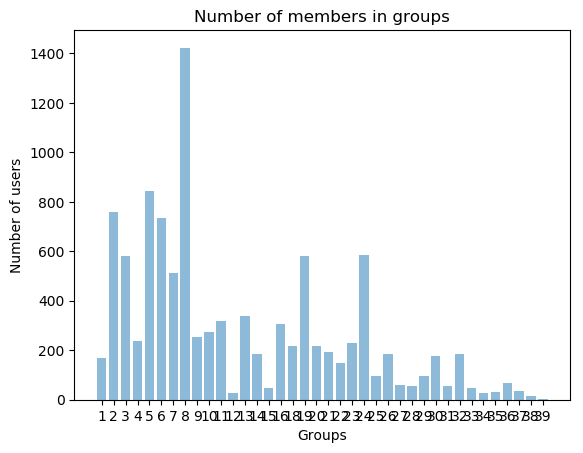

In [36]:
blog_performance = []
blog_objects = groups_freq.index
for i in blog_objects:
    if (i in groups_freq):
        blog_performance.append(groups_freq[i])
y_pos = np.arange(len(blog_objects))

plt.bar(y_pos, blog_performance, align='center', alpha=0.5)
plt.xticks(y_pos, blog_objects)
plt.ylabel('Number of users')
plt.xlabel('Groups')
plt.title('Number of members in groups')

plt.show()

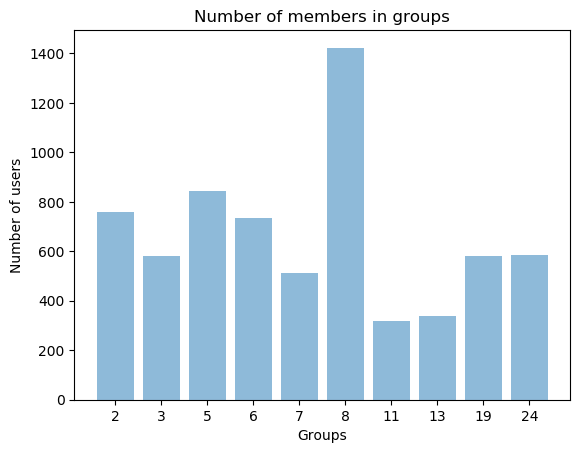

In [38]:
ten_groups_freq = ten_groups['group'].value_counts()
ten_groups_freq = ten_groups_freq.sort_index()

blog_performance_ten = []
blog_objects_ten = ten_groups_freq.index
for i in blog_objects_ten:
    if (i in ten_groups_freq):
        blog_performance_ten.append(ten_groups_freq[i])
y_pos = np.arange(len(blog_objects_ten))

plt.bar(y_pos, blog_performance_ten, align='center', alpha=0.5)
plt.xticks(y_pos, blog_objects_ten)
plt.ylabel('Number of users')
plt.xlabel('Groups')
plt.title('Number of members in groups')

plt.show()

In [41]:
lengths = []
num_ws = []
adj_scs = []
f1_scs = []
clusters_10 = 10

for i in range(80, 90, 10): #walk_length = 80
    for j in range(8, 15, 1): # num_walks = 10
        adj_sc, f1_m = calc_scores(G_blog_ten, groups_dic, clusters_10, i, j)
        adj_scs.append(adj_sc)
        f1_scs.append(f1_m)
        lengths.append(i)
        num_ws.append(j)

blog_walks_test = pd.DataFrame(list(zip(lengths, num_ws, adj_scs, f1_scs)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

walk_length: 80 , num_walks: 8 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|████████████████████████████████████████████████| 8/8 [07:01<00:00, 55.82s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 9 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|████████████████████████████████████████████████| 9/9 [09:42<00:00, 67.55s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [08:52<00:00, 55.66s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 11 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 11/11 [09:46<00:00, 57.31s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 12 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 12/12 [10:26<00:00, 55.03s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 13 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 13/13 [11:50<00:00, 56.92s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 14 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 14/14 [12:24<00:00, 54.54s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


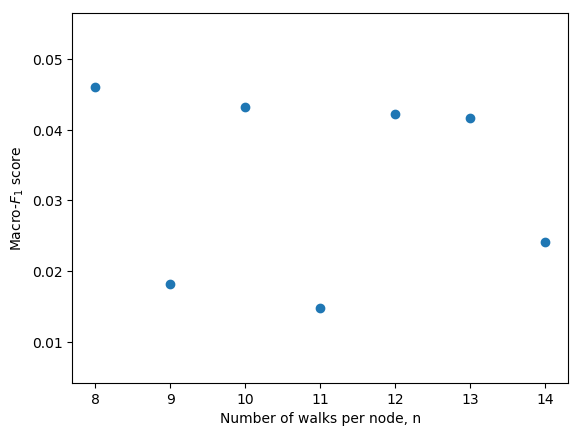

In [42]:
fig = plt.figure()
fig.add_subplot(211)
plt.scatter(blog_walks_test['num_walks'], blog_walks_test['f1_score'])
plt.xlabel('Number of walks per node, n')
plt.ylabel('Macro-$F_1$ score')
plt.show()

fig = plt.figure()
fig.add_subplot(212)
plt.scatter(blog_walks_test['num_walks'], blog_walks_test['adj_score'])
plt.xlabel('Number of walks per node, n')
plt.ylabel('Adjusted rand score')
plt.show()

In [43]:
walk_lengths_arr2 = []
num_walks_arr2 = []
adj_scores2 = []
f1_scores2 = []

for i in range(50, 100, 10): #walk_length = 80
    for j in range(10, 11, 1): # num_walks = 10
        adj_score2, f1_macro2 = calc_scores(G_blog_ten, groups_dic, clusters_10, i, j)
        adj_scores2.append(adj_score2)
        f1_scores2.append(f1_macro2)
        walk_lengths_arr2.append(i)
        num_walks_arr2.append(j)

blog_length_test = pd.DataFrame(list(zip(walk_lengths_arr2, num_walks_arr2, adj_scores2, f1_scores2)), 
               columns =['walk_length','num_walks','adj_score', 'f1_score']) 

walk_length: 50 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [05:32<00:00, 36.89s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 60 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [06:36<00:00, 41.31s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 70 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [07:45<00:00, 48.84s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [08:26<00:00, 53.65s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 90 , num_walks: 10 , p: 1 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [12:24<00:00, 87.37s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


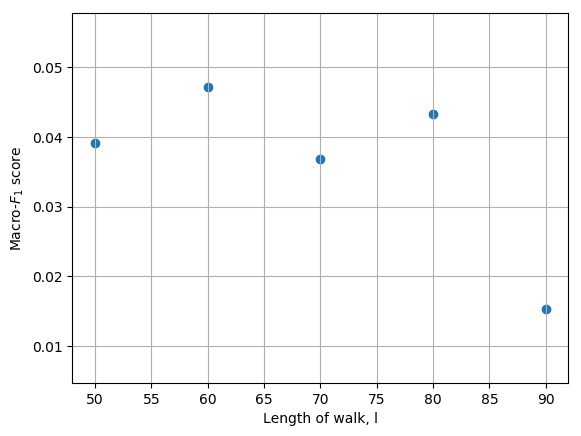

In [46]:
fig = plt.figure()
fig.add_subplot(211)
plt.scatter(blog_length_test['walk_length'], blog_length_test['f1_score'])
plt.xlabel('Length of walk, l')
plt.ylabel('Macro-$F_1$ score')
plt.grid()
plt.show()

fig = plt.figure()
fig.add_subplot(212)
plt.scatter(blog_length_test['walk_length'], blog_length_test['adj_score'])
plt.xlabel('Length of walk, l')
plt.ylabel('Adjusted rand score')
plt.grid()
plt.show()

In [47]:
Ps = []
adj_scores3 = []
f1_scores3 = []

for i in np.arange(0.4, 2, 0.2): #p
    adj_score3, f1_macro3 = calc_scores(G_blog_ten, groups_dic, clusters_10, 80, 10, i)
    adj_scores3.append(adj_score3)
    f1_scores3.append(f1_macro3)
    Ps.append(i)

blog_p_test = pd.DataFrame(list(zip(Ps, adj_scores3, f1_scores3)), 
               columns =['p','adj_score', 'f1_score']) 

walk_length: 80 , num_walks: 10 , p: 0.4 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [09:53<00:00, 66.93s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 0.6000000000000001 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [10:09<00:00, 66.95s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 0.8000000000000002 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [12:14<00:00, 83.94s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.0000000000000002 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [08:33<00:00, 55.54s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.2000000000000002 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [09:18<00:00, 62.97s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.4000000000000004 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [11:05<00:00, 67.28s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.6000000000000005 , q: 1


TEST TES Generating walks (CPU: 1): 100%|██████████████████████████████████████████████| 10/10 [12:38<00:00, 78.13s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


walk_length: 80 , num_walks: 10 , p: 1.8000000000000003 , q: 1


TEST TES Generating walks (CPU: 1): 100%|█████████████████████████████████████████████| 10/10 [19:16<00:00, 134.60s/it]


clustering started


C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\gatauade\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


NameError: name 'blog_p_test' is not defined

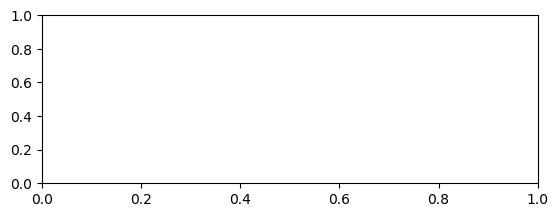

In [54]:
log2Ps = []

for p in Ps:
    log2Ps.append(math.log(p, 2.0))

fig = plt.figure()
fig.add_subplot(211)
plt.scatter(log2Ps, blog_p_test['f1_score'])
plt.xlabel('$\log_2 q$')
plt.ylabel('Macro-$F_1$ score')
plt.grid()
plt.show()

fig = plt.figure()
fig.add_subplot(212)
plt.scatter(log2Ps, blog_p_test['adj_score'])
plt.xlabel('$\log_2 q$')
plt.ylabel('Adjusted rand score')
plt.grid()
plt.show()

In [55]:
Qs = []
adj_scores4 = []
f1_scores4 = []

for i in np.arange(0.4, 2, 0.2): #p
    adj_score4, f1_macro4 = calc_scores(G_blog_ten, groups_dic, clusters_10, 80, 10, 1, i)
    adj_scores4.append(adj_score4)
    f1_scores4.append(f1_macro4)
    Qs.append(i)

blog_q_test = pd.DataFrame(list(zip(Qs, adj_scores4, f1_scores4)), 
               columns =['q','adj_score', 'f1_score']) 

NameError: name 'G_blog_ten' is not defined

NameError: name 'blog_q_test' is not defined

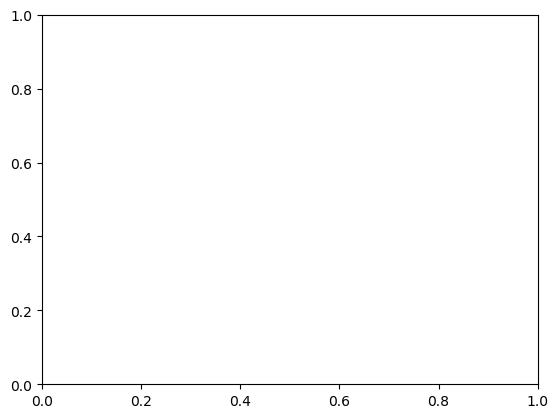

In [56]:
log2Qs = []

for q in Qs:
    log2Qs.append(math.log(q, 2.0))
    
fig = plt.figure()
fig.add_subplot(111)
plt.scatter(log2Qs, blog_q_test['f1_score'])
plt.xlabel('$\log_2 q$')
plt.ylabel('Macro-$F_1$ score')
plt.grid()
plt.show()